In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drugs-a-b-c-x-y-for-decision-trees/drug200.csv


In [2]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [3]:
# get the data
import pandas as pd

df= pd.read_csv('/kaggle/input/drugs-a-b-c-x-y-for-decision-trees/drug200.csv')

In [4]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [5]:
from sklearn.preprocessing import LabelEncoder
le_Sex=LabelEncoder()
le_BP=LabelEncoder()
le_Cholesterol=LabelEncoder()
le_Drug=LabelEncoder()

In [6]:
df['Sex_num'] = le_Sex.fit_transform(df['Sex'])
df['BP_num'] = le_BP.fit_transform(df['BP'])
df['Cholesterol_num'] = le_Cholesterol.fit_transform(df['Cholesterol'])
df['Drug_num'] = le_Drug.fit_transform(df['Drug'])
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Sex_num,BP_num,Cholesterol_num,Drug_num
0,23,F,HIGH,HIGH,25.355,drugY,0,0,0,4
1,47,M,LOW,HIGH,13.093,drugC,1,1,0,2
2,47,M,LOW,HIGH,10.114,drugC,1,1,0,2
3,28,F,NORMAL,HIGH,7.798,drugX,0,2,0,3
4,61,F,LOW,HIGH,18.043,drugY,0,1,0,4


In [7]:
inputs = df.drop(['Sex','BP','Cholesterol','Drug'],axis='columns')

In [8]:
inputs.head()

,Age,Na_to_K,Sex_num,BP_num,Cholesterol_num,Drug_num
0,23,25.355,0,0,0,4
1,47,13.093,1,1,0,2
2,47,10.114,1,1,0,2
3,28,7.798,0,2,0,3
4,61,18.043,0,1,0,4


In [9]:
inputs.fillna(130, inplace = True)

In [10]:
X=inputs.iloc[:,:-1].values
y=inputs.iloc[:,-1].values

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [12]:
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, y_pred)
print(acc)

1.0


In [13]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy',random_state= 0)
classifier.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [14]:
from sklearn.metrics import confusion_matrix,accuracy_score
print(y_test.shape)
cm = confusion_matrix(y_test, y_pred)
print(cm)

accuracy = accuracy_score (y_test, y_pred)*100
print('Accuracy is ' + str(accuracy) + ' %.')

(40,)
[[ 3  0  0  0  0]
 [ 0  1  0  0  0]
 [ 0  0  3  0  0]
 [ 0  0  0 14  0]
 [ 0  0  0  0 19]]
Accuracy is 100.0 %.


In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [16]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
text_representation = tree.export_text(classifier)
print(text_representation)


|--- feature_1 <= 14.83
|   |--- feature_3 <= 0.50
|   |   |--- feature_0 <= 50.50
|   |   |   |--- class: 0
|   |   |--- feature_0 >  50.50
|   |   |   |--- class: 1
|   |--- feature_3 >  0.50
|   |   |--- feature_3 <= 1.50
|   |   |   |--- feature_4 <= 0.50
|   |   |   |   |--- class: 2
|   |   |   |--- feature_4 >  0.50
|   |   |   |   |--- class: 3
|   |   |--- feature_3 >  1.50
|   |   |   |--- class: 3
|--- feature_1 >  14.83
|   |--- class: 4



[Text(0.625, 0.9, 'x[1] <= 14.829\nentropy = 2.008\nsamples = 160\nvalue = [20, 15, 13, 40, 72]'),
 Text(0.5, 0.7, 'x[3] <= 0.5\nentropy = 1.846\nsamples = 88\nvalue = [20, 15, 13, 40, 0]'),
 Text(0.25, 0.5, 'x[0] <= 50.5\nentropy = 0.985\nsamples = 35\nvalue = [20, 15, 0, 0, 0]'),
 Text(0.125, 0.3, 'entropy = 0.0\nsamples = 20\nvalue = [20, 0, 0, 0, 0]'),
 Text(0.375, 0.3, 'entropy = 0.0\nsamples = 15\nvalue = [0, 15, 0, 0, 0]'),
 Text(0.75, 0.5, 'x[3] <= 1.5\nentropy = 0.804\nsamples = 53\nvalue = [0, 0, 13, 40, 0]'),
 Text(0.625, 0.3, 'x[4] <= 0.5\nentropy = 1.0\nsamples = 26\nvalue = [0, 0, 13, 13, 0]'),
 Text(0.5, 0.1, 'entropy = 0.0\nsamples = 13\nvalue = [0, 0, 13, 0, 0]'),
 Text(0.75, 0.1, 'entropy = 0.0\nsamples = 13\nvalue = [0, 0, 0, 13, 0]'),
 Text(0.875, 0.3, 'entropy = 0.0\nsamples = 27\nvalue = [0, 0, 0, 27, 0]'),
 Text(0.75, 0.7, 'entropy = 0.0\nsamples = 72\nvalue = [0, 0, 0, 0, 72]')]

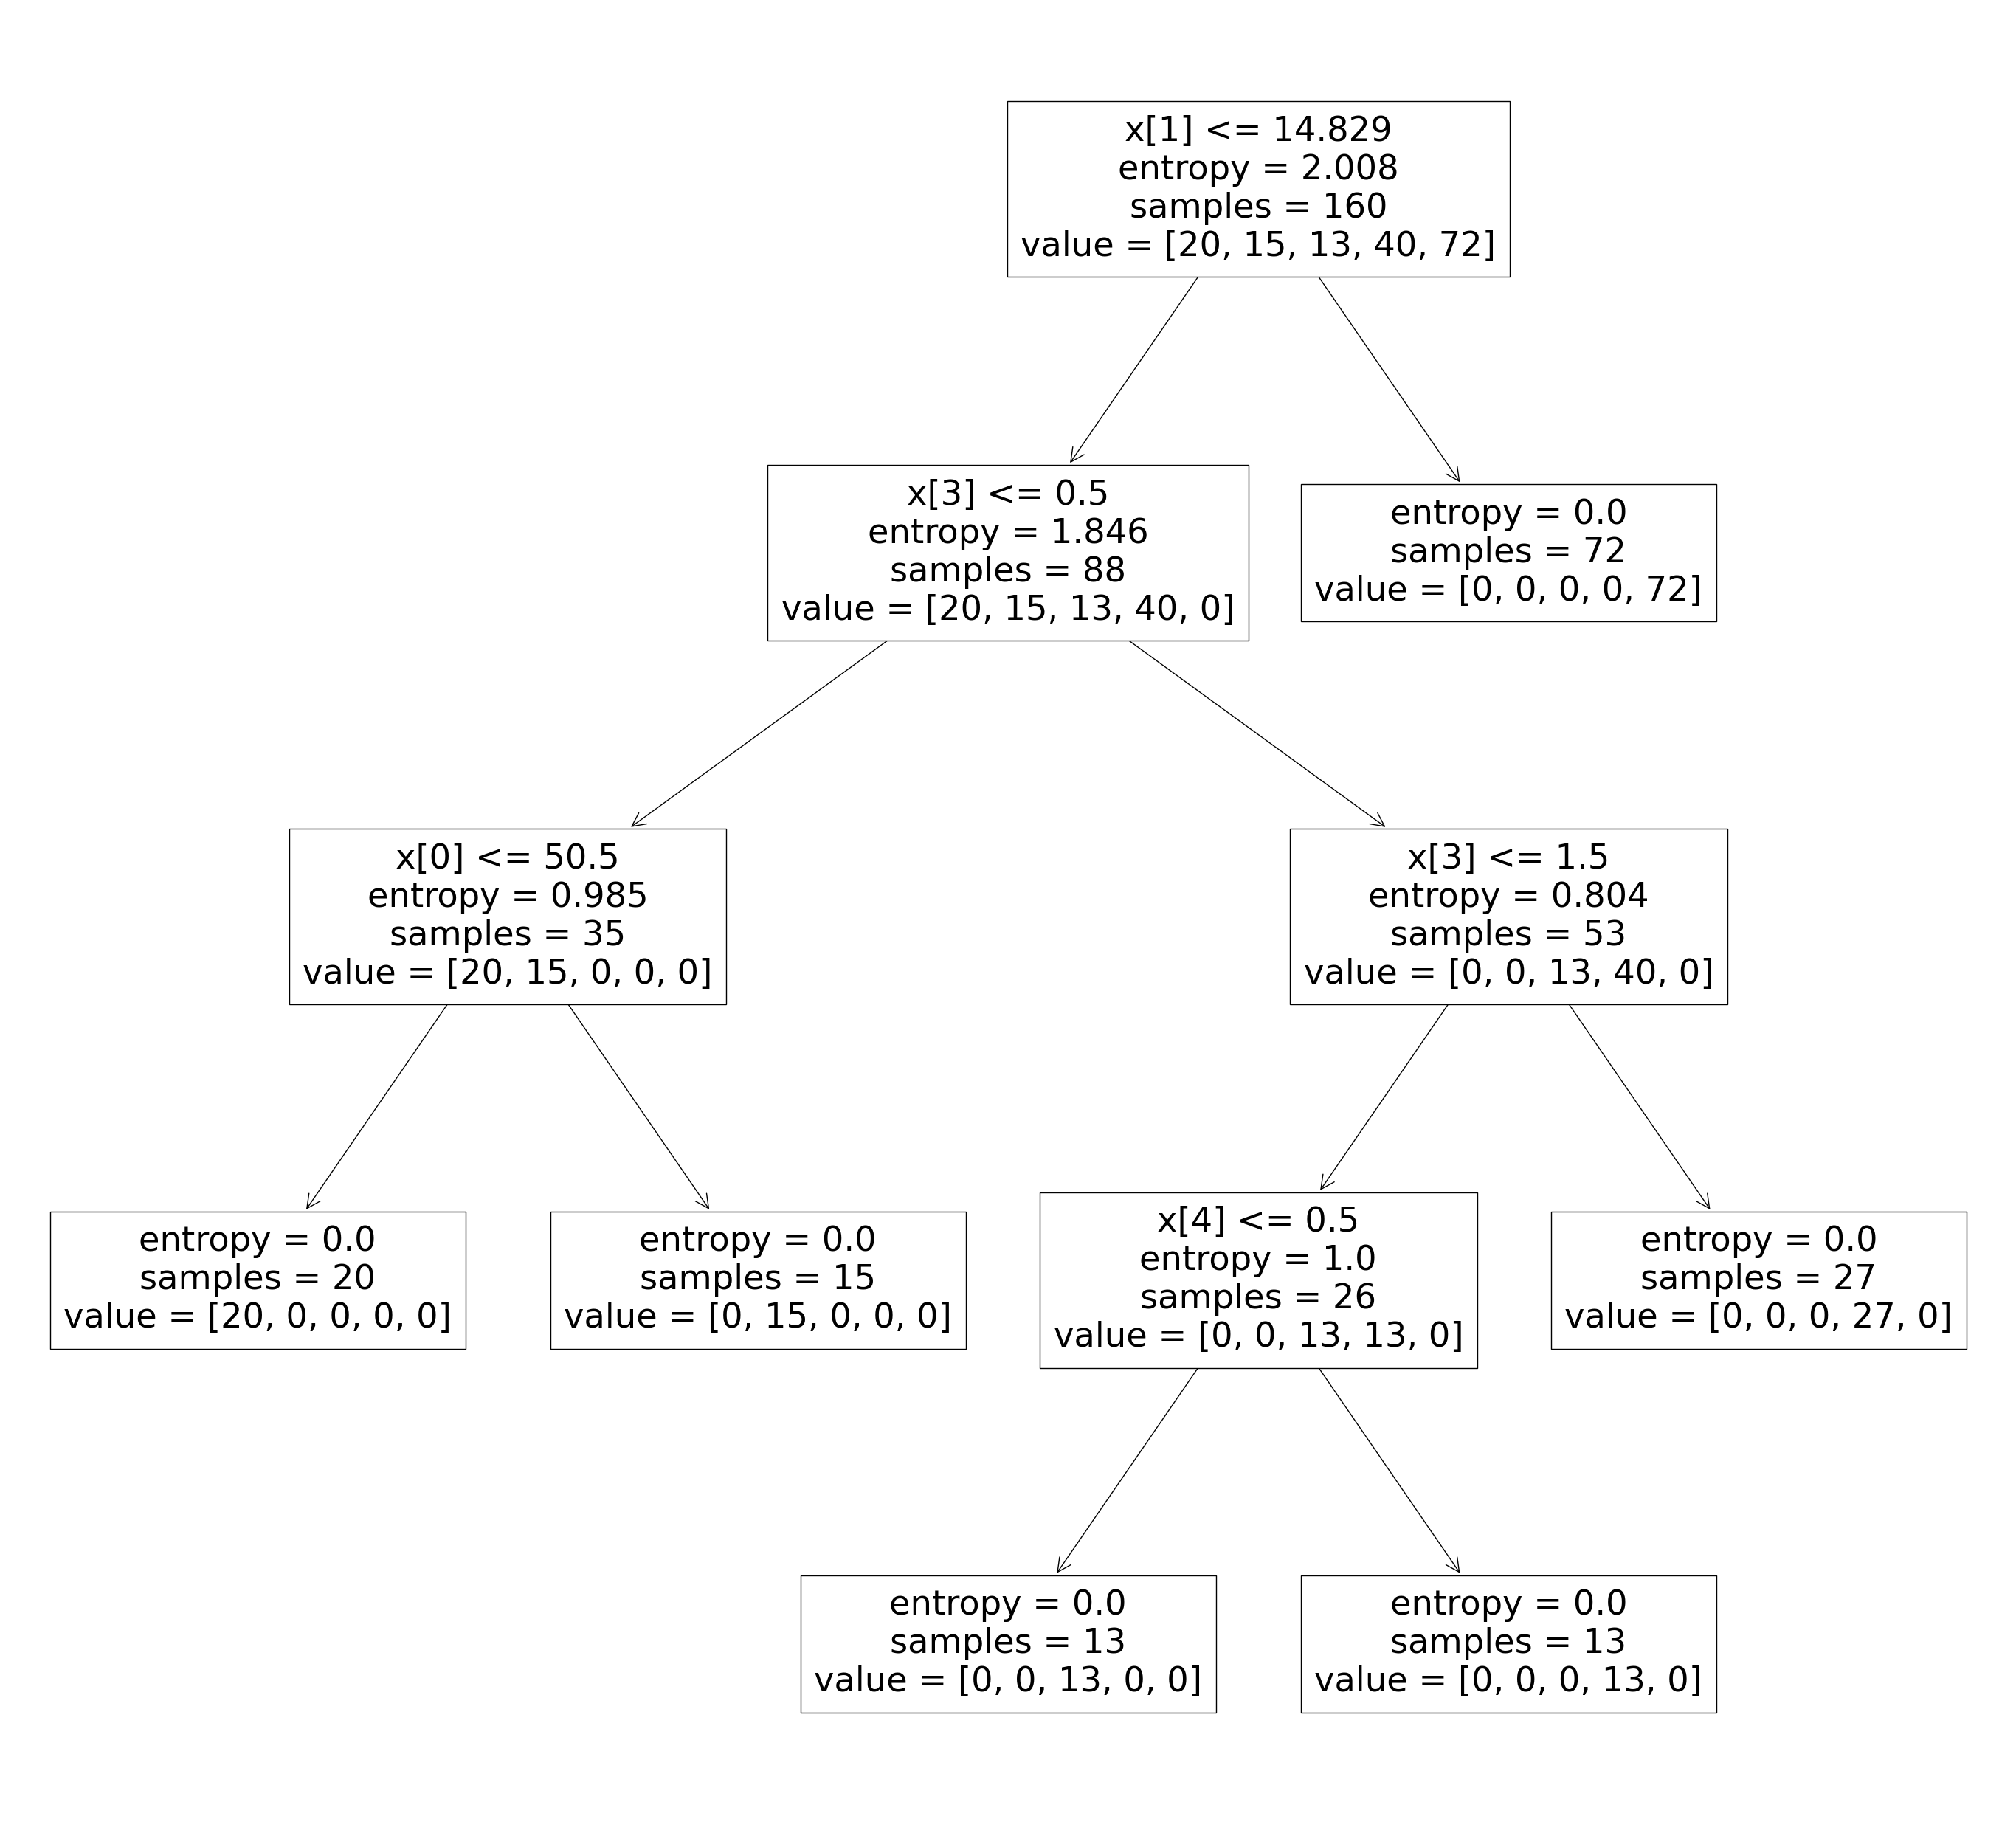

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(35,32))
tree.plot_tree(classifier)